__Étudiante__ : Madina TRAORÉ

#### Imports

In [2]:
import numpy as np
import time
from ipynb.fs.defs.toolbox import softmax
from ipynb.fs.defs.mdp import maze_mdp # Markov Decision Process # RETIRER LES OCCURENCES DE "%notebook" DE mdp.py
                                       # POUR QUE CET IMPORT PUISSE SE FAIRE
from ipynb.fs.defs.maze_plotter import maze_plotter # used for visualization of the state value and policy evolution

# Reinforcement learning functions

By contrast with dynamic programming functions, the reinforcement learning functions are applied when the MDP is unknown.
More precisely, the state and action spaces are known, but the agent does not know the transition nor the reward function.

In this notebook we focus on *model free* reinforcement learning, the model-based case is treated [here](mbrl.ipynb).

## TD learning

Given a state and an action spaces as well as a policy, TD(0) computes the state value of this policy based on the following equation: 
    $$V^{(t+1)}(x_t) = V^{(t)}(x_t) + \alpha\delta_t,$$
    
where $\delta_t = r(x_t,u_t) + \gamma V^{(t)}(x_{t+1})-V^{(t)}(x_t)$ is the TD error and $\alpha$ is a parameter called "learning rate".</span>


The code is provided below, so that you can take inspiration later on. The important part is the computation of $\delta$, and the update of the values of $V$.

Once you have understood the code, write in the cell just below the code to run it.

Hint: to run TD learning, you need a policy as input. You can retreive such a policy by using the policy iteration method defined in the [dynamic_programming.ipynb](dynamic_programming.ipynb) notebook. Just import it, call it, and use the resulting policy as evaluated policy.


In [10]:
# Given state and action spaces and a policy, it computes the state value of this policy

def TD(mdp, pol, nEpisodes=100000, nTimesteps=25, render=True):
    V = np.zeros((mdp.observation_space.size)) #initial state value V
    V_list = [V.copy()]
    alpha = 0.1 #learning rate
    mdp.timeout = 25 #sets timeout of an episode (maximum number of timesteps) - default set to 50
    
    if render:
        mdp.new_render()
    
    for i in range(nEpisodes) : #for each episode
        
        # Draw an initial state randomly (if uniform is set to False, the state is drawn according to the P0 
        #                                 distribution)
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        while not done: #update episode at each timestep
            # Show agent
            if render:
                mdp.render(V, pol)
            
            # Step forward following the MDP: x=current state, 
            #                                 pol[i]=agent's action according to policy pol, 
            #                                 r=reward gained after taking action pol[i], 
            #                                 done=tells whether the episode ended, 
            #                                 and info gives some info about the process
            [y,r,done,info] = mdp.step(int(pol[x])) 
            
            # Update the state value of x
            if x in mdp.terminal_states:
                V[x] = r
            else:
                delta = r+mdp.gamma*V[y]-V[x]
                V[x] = V[x]+alpha*delta
            
            # Update agent's position (state)
            x=y
        
        # After each episode, we save the computed state value V
        V_list.append(V.copy())
        policy_list.append(pol.copy())
    
    if render :
        mdp.render(V, pol)
    
    return V_list,policy_list

In [11]:
########################### Policy Iteration ###########################
# Given a MDP, this algorithm computes the optimal state value function V
# It then derives the optimal policy based on this function

def PI_V(mdp, render=True): #Value Iteration using the state value V
     
    V = np.zeros((mdp.observation_space.size)) #initial state values are set to 0
    pol = np.zeros((mdp.observation_space.size)) #initial policy set to always go north
    quitt = False
    
    V_list = [V.copy()] #list of the state values computed over time (used to generate an animation)
    policy_list = [pol.copy()] #list of the policies computed over time (used to generate an animation)
    
    if render:
        mdp.new_render()
    
    i = 0
    while quitt==False:
        i += 1
        Vold = V.copy()
        if render:
            mdp.render(V, pol)
        
        # Step 1 : Policy Evaluation
        for x in mdp.observation_space.states: #for each state x
            # Compute the value of the state x 
            
            if not x in mdp.terminal_states:
                # Process sum of the values of the neighbouring states
                v = 0
                for y in mdp.observation_space.states:
                    v += mdp.r[x,int(pol[x])] + mdp.gamma*mdp.P[x,int(pol[x]),y]*Vold[y]
                V[x] = v
            else : # if it is a final state, then we only take the reward into account
                v = mdp.r[x,int(pol[x])]
                V[x] = v

        # Step 2 : Policy Improvement
        
        for x in mdp.observation_space.states:
            V_temp = []
            for u in mdp.action_space.actions:
                v = 0
                for y in mdp.observation_space.states:
                    v += mdp.r[x,u] + mdp.gamma*mdp.P[x,u,y]*V[y]
                V_temp.append(v)
            # Set the policy for this state as the action u that maximizes the state value of x
            pol[x] = np.argmax(V_temp)
        
        V_list.append(V.copy())
        policy_list.append(pol.copy())
    
        # Test if convergence has been reached
        if i > 10 and (np.linalg.norm(V-Vold)) < 0.01 :
            quitt = True
    
    if render:
        mdp.render(V, pol)
    
    return [V_list, policy_list]

<IPython.core.display.Javascript object>


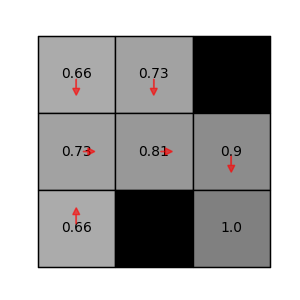

In [12]:
%matplotlib notebook

walls = [5,6]
height = 3
width = 3
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)

[V_list, policy_list] = PI_V(m,render=True)

<IPython.core.display.Javascript object>


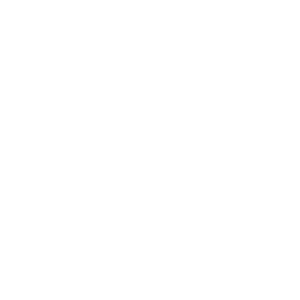

KeyboardInterrupt: 

In [13]:
V_list, polPI_list = TD(m,policy_list[-1],100)

## Q-learning

The QLearning algorithm accounts for an agent exploring an MDP and updating at each step a model of the state action-value function stored into a Q-table. It is updated as follows:
    $$Q^{(t+1)}(x_t,u_t) = Q_{(t)}(x_t,u_t) + \alpha \delta_t,$$
    
and the temporal difference error is processed using $\delta_t = r(x_t,u_t) + \gamma \max_{u_{t+1} \in A} Q^{(t)}(x_{t+1},u_{t+1})-Q^{(t)}(x_t,u_{t})$

The cell below gives the code of Q-learning, where you must just write the central update rule.


In [14]:
########################### Q-Learning ###########################
    
# Given a temperature "tau", the QLearning function computes the state action-value function 
# based on a softmax policy 
def QLearning(mdp,tau,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
    
    steps = 0
    for i in range(nEpisodes) :
        #Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        while not done:
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action using a soft-max policy
            u = mdp.action_space.sample(prob_list=softmax(Q,x,tau))

            # Perform a step of the MDP
            [y,r,done,info] = mdp.step(u)

            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                Qmax = Q.max(axis=1)
                delta = r + mdp.gamma*Qmax[y] - Q[x,u]
                Q[x,u] += alpha*delta
            
            # Update agent's position
            x = y
            
            steps += 1
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
    
    print("Nombre de steps :", steps)
    print(Q)

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

Now, write the code to run Q-learning below

<IPython.core.display.Javascript object>


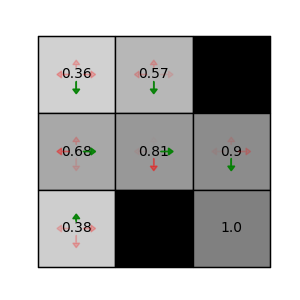

Nombre de steps : 695
[[0.02859159 0.3591767  0.03470255 0.04077866]
 [0.02916638 0.01333756 0.68169816 0.07912223]
 [0.38390941 0.03111623 0.03768737 0.02101583]
 [0.02229083 0.56787654 0.00781535 0.02056943]
 [0.00116274 0.08691667 0.80824906 0.00546684]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.0081     0.89985666 0.021951   0.00322218]
 [0.         0.         0.         1.        ]]


In [21]:
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1)

<IPython.core.display.Javascript object>


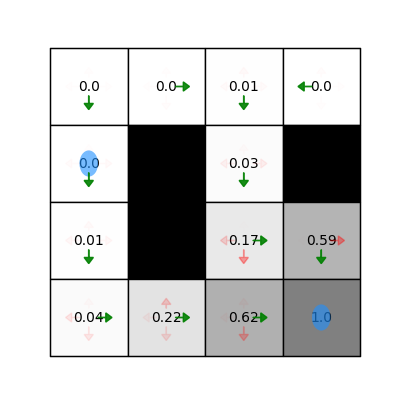

KeyboardInterrupt: 

In [8]:
walls = [5,6,13]
height = 4
width = 4
terminal_states=[width*height-1]
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states)
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1)

In [41]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1,render=False)
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 544
[[3.61386123e-02 4.72664518e-02 3.40382987e-01 1.63648220e-02]
 [7.71601011e-04 1.22230642e-02 5.13575559e-01 1.93729309e-02]
 [1.46581363e-01 1.89546557e-02 1.76352924e-02 1.90493704e-02]
 [2.91289760e-02 6.71316537e-01 1.54484650e-03 5.90915321e-03]
 [0.00000000e+00 1.70560682e-02 8.06842682e-01 9.60792840e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.99840732e-01 8.10000000e-03 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]]
Temps d'exécution : 0.06942248344421387


 ### Learning dynamics
    
If you watch carefully the values while the agent is learning, you will see that the agent favors certain paths over others which have a strictly equivalent value. This can be explained easily: as the agent chooses a path for the first time, it updates the values along that path, these values get higher than the surrounding values, and the agent will choose the same path again and again, increasing the phenomenon. Only steps of random exploration can counterbalance this effect, but they do so extremely slowly.

### Effect of hyper-parameters

There are three hyper-parameters in Q-learning: the softmax temperature $\tau$, the learning rate $\alpha$, and the discount factor $\gamma$. Using a small maze, try various values for these hyper-parameters and explain what is happenning.



Faisons varier l'hyper-paramètre $\tau$

<IPython.core.display.Javascript object>


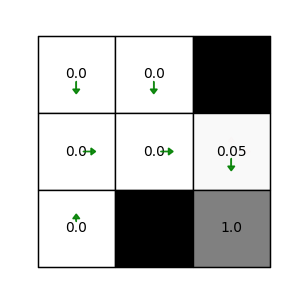

Nombre de steps : 2385
[[9.09988113e-09 8.64900724e-07 8.04883143e-07 1.76876028e-08]
 [1.49056710e-08 1.89488596e-08 4.57363019e-05 8.28852180e-07]
 [1.10102172e-06 2.11227735e-08 1.69467942e-08 1.93946877e-08]
 [8.38634287e-07 4.37384305e-05 1.19180088e-06 1.05665394e-08]
 [7.42244555e-07 4.25644531e-05 1.62180498e-03 1.03493381e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [7.89892402e-04 4.52843358e-02 7.87746779e-04 1.99193360e-05]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]


In [40]:
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.01)

In [43]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=1000,nTimesteps=50,alpha=0.01,render=False)
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 5944
[[0.0284132  0.29925103 0.08195133 0.02423897]
 [0.00791549 0.00615536 0.67447139 0.04075901]
 [0.31537769 0.03123306 0.03354967 0.02840084]
 [0.03581119 0.50298971 0.04452051 0.01109357]
 [0.00720914 0.03059281 0.80648109 0.00665823]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.02668211 0.89978332 0.01522232 0.00310199]
 [0.         1.         0.         0.        ]]
Temps d'exécution : 0.4049413204193115


<IPython.core.display.Javascript object>


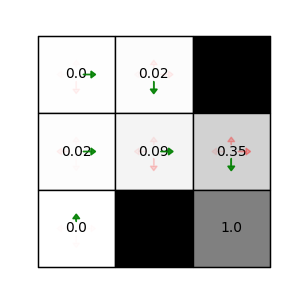

Nombre de steps : 2406
[[6.42552125e-04 4.02539297e-03 4.78352723e-03 7.96703228e-04]
 [9.12361417e-04 6.85586836e-04 1.91704313e-02 3.34099908e-03]
 [3.80318423e-03 8.19138928e-04 5.86204084e-04 5.44454131e-04]
 [4.76743780e-03 2.29133052e-02 4.89363194e-03 8.56036420e-04]
 [3.57959484e-03 1.73732838e-02 8.76809162e-02 3.06666307e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.64498042e-02 3.49994484e-01 7.19659916e-02 7.97458402e-03]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]


In [19]:
QPI_list, polPI_list = QLearning(m,0.5,nEpisodes=100,nTimesteps=50,alpha=0.01) # gamma = 0.9

In [20]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.5,nEpisodes=100,nTimesteps=50,alpha=0.01,render=False) # gamma = 0.9
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 2580
[[0.00147031 0.00792206 0.00595588 0.00150647]
 [0.00176295 0.00178957 0.03224856 0.00709691]
 [0.00880891 0.00141613 0.00202326 0.0021174 ]
 [0.004259   0.02807948 0.00454673 0.00124669]
 [0.0042564  0.02546797 0.12013861 0.00665445]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.05601775 0.40258487 0.04829274 0.01023685]
 [1.         1.         1.         1.        ]]
Temps d'exécution : 0.2848026752471924


<IPython.core.display.Javascript object>


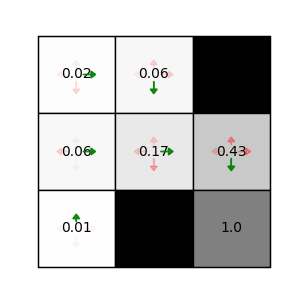

Nombre de steps : 2575
[[0.00284277 0.01244781 0.01675786 0.00309101]
 [0.00323797 0.00194508 0.05581467 0.01492689]
 [0.01114705 0.00201453 0.00190431 0.00222776]
 [0.01574313 0.0592264  0.01626521 0.00343924]
 [0.01298839 0.04365263 0.17030853 0.01442765]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.11086182 0.42696316 0.10728288 0.03208314]
 [1.         1.         1.         1.        ]]


In [21]:
QPI_list, polPI_list = QLearning(m,0.9,nEpisodes=100,nTimesteps=50,alpha=0.01) # gamma = 0.9

In [22]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.9,nEpisodes=100,nTimesteps=50,alpha=0.01,render=False) # gamma = 0.9
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 2416
[[8.76387385e-04 7.35816967e-03 5.16334500e-03 1.38855875e-03]
 [1.17361087e-03 1.53623190e-03 3.32463856e-02 7.50620112e-03]
 [8.44002854e-03 1.97800344e-03 1.70878486e-03 1.88266744e-03]
 [7.35065559e-03 3.11387069e-02 6.19820903e-03 1.08611919e-03]
 [6.36227015e-03 2.96728416e-02 1.24349974e-01 5.24041532e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [5.09369685e-02 3.66330198e-01 5.96335990e-02 2.04130699e-02]
 [1.00000000e+00 1.00000000e+00 1.00000000e+00 1.00000000e+00]]
Temps d'exécution : 0.21635007858276367


Faisons varier l'hyper-paramètre $\alpha$

<IPython.core.display.Javascript object>


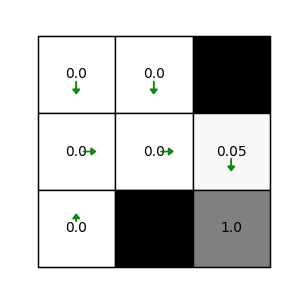

Nombre de steps : 2381
[[3.62807021e-08 1.91094649e-06 1.54424490e-06 3.42393105e-08]
 [4.06396575e-08 4.58891462e-08 7.52029613e-05 2.06421810e-06]
 [2.19356446e-06 4.35920003e-08 3.46190128e-08 4.46260299e-08]
 [1.50445278e-06 6.65727707e-05 1.05855538e-06 2.81632820e-08]
 [1.17245689e-06 6.28851943e-05 2.07113021e-03 1.82288683e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.16067723e-04 5.15889530e-02 1.00856364e-03 2.76410200e-05]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]


In [14]:
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.001) # gamma = 0.9

In [15]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.001,render=False) # gamma = 0.9
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 2349
[[5.12862222e-08 1.91762037e-06 1.56910391e-06 5.09189475e-08]
 [4.71145599e-08 2.75950173e-08 7.48387590e-05 1.79753476e-06]
 [1.56216644e-06 2.59833876e-08 2.25810200e-08 1.92863241e-08]
 [1.56939143e-06 5.18740730e-05 1.46412006e-06 4.74908279e-08]
 [7.06543402e-07 4.06582562e-05 2.09698798e-03 1.85949869e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [1.08107529e-03 5.15889530e-02 9.29635520e-04 2.38671627e-05]
 [1.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]]
Temps d'exécution : 0.29729175567626953


<IPython.core.display.Javascript object>


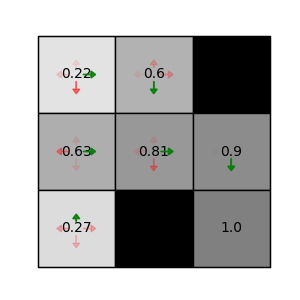

Nombre de steps : 943
[[0.01286153 0.16721048 0.21698186 0.0301074 ]
 [0.00965263 0.00948223 0.63427639 0.06791839]
 [0.2714113  0.02800917 0.0458381  0.04415335]
 [0.03068995 0.60310232 0.03787998 0.00485719]
 [0.00788852 0.0530171  0.80710969 0.00667248]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.         0.89982304 0.         0.0013851 ]
 [0.         0.         1.         0.        ]]


In [16]:
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1) # gamma = 0.9

In [17]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1,render=False) # gamma = 0.9
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 715
[[1.88935829e-02 4.03206981e-01 1.06761099e-02 4.85609356e-02]
 [7.71580019e-03 2.17471078e-02 6.97568556e-01 5.95369499e-02]
 [3.67098212e-01 2.89539073e-02 4.47076890e-02 1.09806395e-01]
 [1.41004711e-02 4.18280525e-01 1.77835092e-02 1.03553542e-02]
 [3.44479531e-04 4.13244479e-02 8.07973704e-01 9.50616971e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [2.19510000e-02 8.99870993e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
Temps d'exécution : 0.10033130645751953


<IPython.core.display.Javascript object>


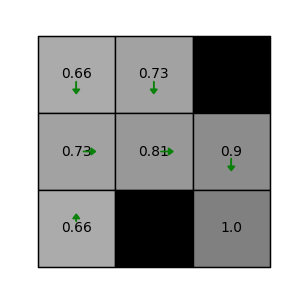

Nombre de steps : 458
[[0.     0.6561 0.     0.    ]
 [0.     0.     0.729  0.    ]
 [0.6561 0.     0.     0.    ]
 [0.     0.729  0.     0.    ]
 [0.     0.     0.81   0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.     0.     0.    ]
 [0.     0.9    0.     0.    ]
 [0.     1.     0.     0.    ]]


In [18]:
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=1) # gamma = 0.9

In [ ]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=1,render=False) # gamma = 0.9
t = time.time() - start_time
print("Temps d'exécution :",t)

Faisons varier l'hyper-paramètre $\gamma$

<IPython.core.display.Javascript object>


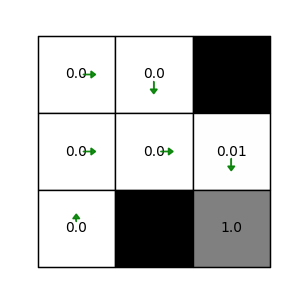

Nombre de steps : 2505
[[9.39200892e-11 9.58237285e-09 9.62372112e-09 9.14628574e-11]
 [9.36682556e-11 9.22706921e-11 9.72976894e-07 9.57776126e-09]
 [9.55896587e-09 9.16117340e-11 9.33204586e-11 9.31415613e-11]
 [9.61069183e-09 9.76203814e-07 9.50496281e-09 9.31588972e-11]
 [9.49595885e-09 9.75105816e-07 9.86128162e-05 9.40229680e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [9.72912101e-05 9.94846225e-03 9.73281659e-05 9.34017595e-07]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [19]:
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states,gamma=0.01)
QPI_list, polPI_list = QLearning(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1)

In [20]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.01,nEpisodes=100,nTimesteps=50,alpha=0.1,render=False)
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 2575
[[9.49522887e-11 9.72480587e-09 9.75440887e-09 9.60213137e-11]
 [9.49646089e-11 9.50343803e-11 9.88543837e-07 9.71230304e-09]
 [9.76423592e-09 9.55780356e-11 9.67841840e-11 9.57518950e-11]
 [9.76903607e-09 9.89328969e-07 9.81208911e-09 9.53723684e-11]
 [9.74623550e-09 9.81544682e-07 9.94815265e-05 9.69438374e-09]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [8.45322163e-05 9.99140496e-03 9.27119174e-05 8.63100696e-07]
 [0.00000000e+00 0.00000000e+00 1.00000000e+00 0.00000000e+00]]
Temps d'exécution : 0.3495495319366455


<IPython.core.display.Javascript object>


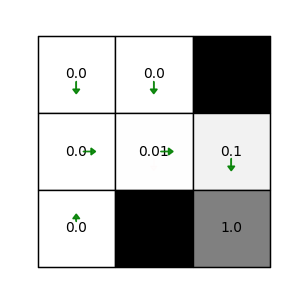

Nombre de steps : 1431
[[7.81521461e-06 9.14120238e-05 9.01481901e-05 7.85513582e-06]
 [7.66791011e-06 7.80498162e-06 9.71634399e-04 8.80240445e-05]
 [9.16398155e-05 7.68912595e-06 8.24507044e-06 8.17853218e-06]
 [8.76899318e-05 9.62513778e-04 8.92162315e-05 7.95401429e-06]
 [7.79181551e-05 8.29248755e-04 9.96444907e-03 6.81391815e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99781525e-02 1.00000000e-04 9.20800000e-06]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [21]:
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states,gamma=0.1)
QPI_list, polPI_list = QLearning(m,0.01,nEpisodes=100,nTimesteps=50,alpha=0.1)

In [22]:
start_time = time.time()
QPI_list, polPI_list = QLearning(m,0.01,nEpisodes=100,nTimesteps=50,alpha=0.1,render=False)
print("Temps d'exécution :",t)

Nombre de steps : 1456
[[6.95449318e-06 9.14902372e-05 8.56786265e-05 7.49807157e-06]
 [7.67671629e-06 8.95253474e-06 9.79043248e-04 9.18184457e-05]
 [9.59227830e-05 8.69857145e-06 8.65285903e-06 8.87678844e-06]
 [8.64098716e-05 9.69110630e-04 8.98642642e-05 7.49278887e-06]
 [8.14988288e-05 9.15085236e-04 9.96673533e-03 8.45935411e-05]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 9.99781525e-02 0.00000000e+00 2.80000000e-06]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 1.00000000e+00]]
Temps d'exécution : 0.15895891189575195


### Exploration


In the code above, action selection is based on a soft-max policy. Instead, it could have relied on *epsilon-greedy*.
Copy-paste the above code below and do the replacement.

In [27]:
###########################  Epsilon-greedy Q-Learning ###########################
    
# Given a temperature "tau" and an epsilon the Epsilon-greedy QLearning function computes the state action-value
# function based on a softmax policy 
def QLearningEpsilonGreedy(mdp,tau,epsilon,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
     
    steps = 0
    for i in range(nEpisodes) :
        #Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        while not done:
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action using a soft-max policy
            prob_list = np.ones(mdp.action_space.size) * (epsilon / mdp.action_space.size)
            best_action = np.argmax(Q[x])
            prob_list[best_action] += 1 - epsilon
            u = mdp.action_space.sample(prob_list=prob_list)

            # Perform a step of the MDP
            [y,r,done,info] = mdp.step(u)

            # Update the state-action value function with Q-Learning
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                delta = r + mdp.gamma*max([Q[y,u1] for u1 in mdp.action_space.actions]) - Q[x,u]
                Q[x,u] += alpha*delta
            
            # Update agent's position
            x = y
            
            steps += 1
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
    
    print("Nombre de steps :", steps)
    print(Q)

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

<IPython.core.display.Javascript object>


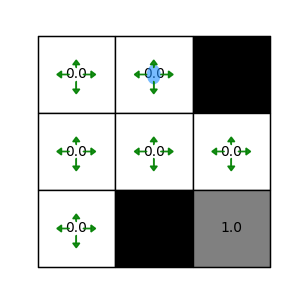

Nombre de steps : 4118
[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [1. 0. 0. 0.]]


In [32]:
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states,gamma=0.9)
QPI_list, polPI_list = QLearningEpsilonGreedy(m,0.1,0.01,nEpisodes=100,nTimesteps=50,alpha=0.1)

In [33]:
start_time = time.time()
QPI_list, polPI_list = QLearningEpsilonGreedy(m,0.1,0.01,nEpisodes=100,nTimesteps=50,alpha=0.1,render=False)
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 4062
[[0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.    0.    0.   ]
 [0.    0.171 0.    0.   ]
 [1.    0.    0.    0.   ]]
Temps d'exécution : 0.28905701637268066


## SARSA

The SARSA algorithm is very similar to Q_learning. At first glance, the only difference is in the update rule. However, to perform the update in SARSA, one needs to know the action the agent will take when it will be at the next state, even if the agent is taking a random action.

This implies that the next state action is determined in advance and stored for being played at the next time step.


By taking inspiration from the above Qlearning function, write in the cell below a Sarsa function that implements the corresponding algorithm. Then write the code to run it in the cell after.

In [29]:
def SARSA(mdp,tau,nEpisodes=100000,nTimesteps=50,alpha=0.01,render=True):
    # Initialize the state-action value function
    # alpha is the learning rate
    Q = np.zeros((mdp.observation_space.size,mdp.action_space.size))
    
    Q_list = []
    policy_list = []
    
    # Run learning cycle
    mdp.timeout = nTimesteps #episode length
    
    if render:
        mdp.new_render()
    
    steps = 0
    for i in range(nEpisodes) :
        #Draw the first state of episode i using a uniform distribution over all the states
        x = mdp.reset(uniform=True) 
        done = mdp.done()
        while not done:
            if render :
                # Show the agent in the maze
                mdp.render(Q, Q.argmax(axis=1))
            
            # Draw an action using a soft-max policy
            u = mdp.action_space.sample(prob_list=softmax(Q,x,tau))

            # Perform a step of the MDP
            [y,r,done,info] = mdp.step(u)

            # Update the state-action value function
            if x in mdp.terminal_states:
                Q[x,u] = r
            else:
                next_u = mdp.action_space.sample(prob_list=softmax(Q,y,tau))
                delta = r + mdp.gamma*Q[y,next_u] - Q[x,u]
                Q[x,u] += alpha*delta
            
            # Update agent's position
            x = y
            
            steps += 1
            
        # Save state-action value after each episode
        Q_list.append(Q.copy())
        policy_list.append(Q.argmax(axis=1))
        
    print("Nombre de steps :", steps)
    print(Q)

    if render :
        # Show the agent in the maze
        mdp.render(Q, Q.argmax(axis=1))
    return [Q_list, policy_list]

<IPython.core.display.Javascript object>


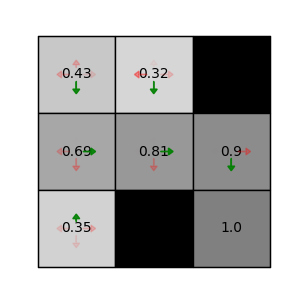

Nombre de steps : 802
[[2.55521907e-02 4.31303899e-01 7.46148102e-03 2.56362810e-02]
 [4.47049632e-04 3.83766357e-02 6.93849305e-01 2.76462310e-02]
 [3.50228400e-01 7.04134524e-03 2.10111374e-02 9.59968868e-03]
 [3.75163808e-03 3.20285709e-01 2.62056620e-02 7.92658483e-02]
 [1.34603094e-04 2.93552142e-02 8.07502144e-01 3.09174948e-04]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.99823036e-01 4.04603100e-02 7.29000000e-04]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]]


In [37]:
m = maze_mdp(width, height, walls=walls, terminal_states=terminal_states,gamma=0.9)
QPI_list, polS_list = SARSA(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1)

In [38]:
start_time = time.time()
QPI_list, polS_list = SARSA(m,0.1,nEpisodes=100,nTimesteps=50,alpha=0.1,render=False)
t = time.time() - start_time
print("Temps d'exécution :",t)

Nombre de steps : 748
[[1.27252733e-03 3.47064957e-03 1.71669373e-01 1.20900112e-03]
 [1.44669499e-03 0.00000000e+00 6.33693041e-01 3.88930480e-03]
 [2.95414021e-01 3.30534730e-02 4.71029865e-02 2.29270922e-02]
 [3.31085081e-02 5.30221022e-01 2.64759686e-03 1.34382289e-03]
 [2.12807621e-05 5.81593820e-02 8.05519029e-01 1.82345917e-03]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 8.99700309e-01 0.00000000e+00 0.00000000e+00]
 [0.00000000e+00 1.00000000e+00 0.00000000e+00 0.00000000e+00]]
Temps d'exécution : 0.11230611801147461


## Wrapping up

Compare the number of steps needed by Qlearning and Sarsa to converge on the given MDP. To figure out, add a counter of number of steps to your various algorithms, and run them for a given number of steps (for instance, 10.000). Then watch the corresponding Q-table: can you determine if one was updated more than another? Eventually, do so with much smaller mazes...